In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *


directory = '/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

filename_prefix = directory + '/TKEBudget_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

steps = sorted(reader.steps)
print("Steps: {}".format(steps))

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
Steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 30, 32, 34, 36, 38, 40, 42, 44, 50, 54, 58, 62, 66, 70, 74]


(2.0, 1.0)


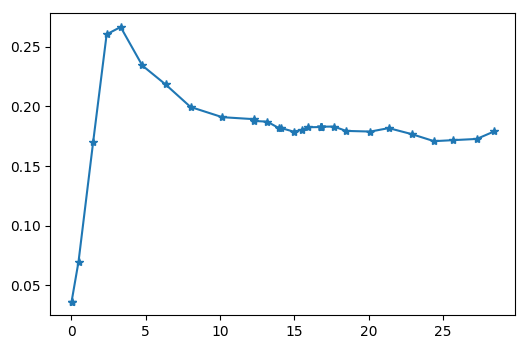

In [3]:
# Integrated profiles

def integrate_term(reader,steps,term):
    
    mat = np.zeros([len(steps),2])
    for i,step in enumerate(steps):
        reader.step = step
        time = reader.time

        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]

        dat = reader.readData(term)
        
        # integrate
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(dat))
    
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]
        
fig = plt.figure(dpi=100)
matP = integrate_term(reader,steps,'production')
matD = integrate_term(reader,steps,'dissipation')
plt.plot(matP[:,0]/inp.du,matD[:,1],'-*')
print(inp.Mc,inp.rr)

2.0:[-0.0206598932105,0.00818160113612],
(2.0, 1.0)


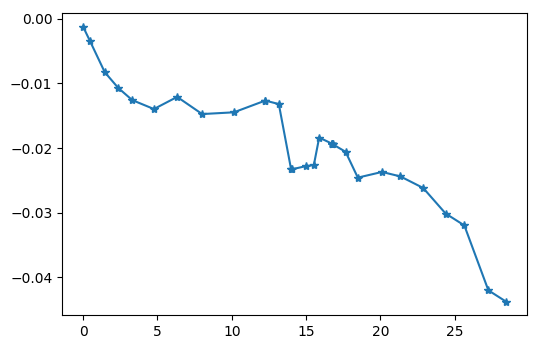

In [13]:
# Get tID
def get_tIDlist(directory):
    flist = glob.glob(directory+"/shearlayer_*xmf")
    flist.sort()
    flist = flist[1:]
    tIDlist = np.zeros([len(flist),2])
    for i,fname in enumerate(flist):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)
        tIDlist[i,0] = time
        tIDlist[i,1] = tID
    return tIDlist
def get_rbar(Mc):
    if Mc == 2: return 0.7
    elif Mc==1.6: return 0.8
    elif Mc==1.2: return 0.85
    elif Mc==0.8: return 0.95
    elif Mc==0.4: return 0.98
    elif Mc==0.2: return 0.995
    
def scale_term(directory,reader,steps,term):
    tIDlist = get_tIDlist(directory)
    mat = np.zeros([len(steps),2])
    for i,step in enumerate(steps):
        reader.step = step
        time = reader.time
        
        idx = np.argmin(abs(time-tIDlist[:,0]))
        tID = tIDlist[idx,1]
        
        # Get dtheta
        idx = np.argmin(abs(tlist-time))
        dtheta = dlist[idx]
        
        # Get dtheta
        dtheta = get_dtheta(directory,time)

        # Get lscale y
        autocorr = np.fromfile(directory+'lscale_vv_%04d.dat'%(tID),sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        ly,i1,i2 = get_lscale(y,autocorr[:,0])
        
        # Get 99% lengthscale
        utilde = np.fromfile( directory+'shearlayer_utilde_%04d.dat'%tID, sep=' ')
        L99,i1,i2 = get_L99(-y,-utilde)
        
        # integrate
        dat = reader.readData(term)
        dudy = inp.du / L99
        scale = (inp.du*ly/dtheta)**2 * dudy * get_rbar(inp.Mc)
        mat[i,0] = time
        mat[i,1] = integrate_y(y,np.squeeze(dat)) / scale / L99
    
    # sort by time
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]
        

fig = plt.figure(dpi=100)
mat = scale_term(directory,reader,steps[1:],'R_12')
f = mat[:,1]
plt.plot(mat[:,0]/inp.du,mat[:,1],'-*')
idx = 2
print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
print(inp.Mc,inp.rr)

In [ ]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']

fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    steps = reader.steps

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')
    
    mat = scale_term(directory,reader,steps[:],'dissipation')
    #mat = integrate_term(reader,steps,'dissipation')
    t = mat[:,0]
    f = mat[:,1]
    plt.plot(t,f,'-*',label='Mc={}'.format(inp.Mc))
    
    idx = 2
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[idx:]),np.std(f[idx:])))
    
print('Done')
plt.grid(True)
plt.legend()
plt.xlim([0,200])
# ax[0].set_ylim([-5e-4,1e-3])
# plt.savefig('/home/kmatsuno/ShearLayer_img/vs_t/'+'diss_s%s'%s,dpi=200,bbox_inches='tight')

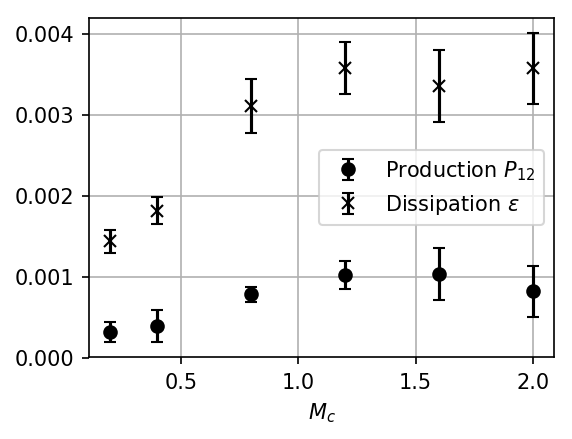

In [6]:
prod = {
0.2:[0.000318870316419,0.000125234495132],
0.4:[0.000394662517956,0.000199685585582],
0.8:[0.000782856945129,9.62955897386e-05],
1.2:[0.00101800804794,0.000172559433891],
1.6:[0.00103279264502,0.000320385771619],
2.0:[0.000818715663743,0.000318817992458],
}
diss = {
0.2:[0.00143701261034,0.000139456200893],
0.4:[0.00181731204954,0.000165935224246],
0.8:[0.00310778034047,0.000328730645707],
1.2:[0.00357820075901,0.000318249074369],
1.6:[0.00335861795633,0.000442970721879],
2.0:[0.00357090409314,0.000435806161689],
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)
fig = plt.figure(figsize=(4,3),dpi=150)
plotter(prod,r'Production $P_{12}$','ko')
plotter(diss,r'Dissipation $\epsilon$','kx')
plt.xlabel(r'$M_c$')
plt.legend()
plt.grid(True)

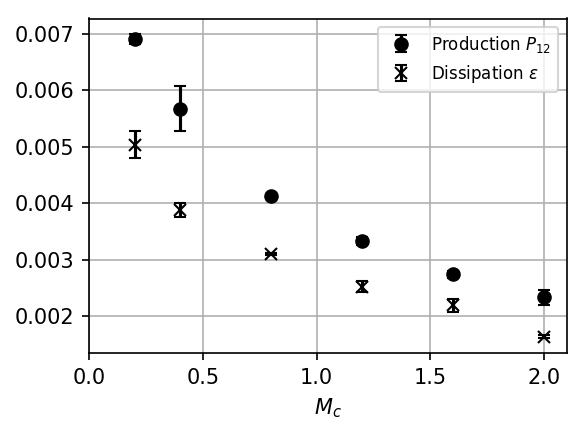

In [5]:
# Rij vs. Mc
prod = {
0.2:[0.0069131294931,8.78328315999e-05],
0.4:[0.00567523508046,0.000395412567946],
0.8:[0.0041233690618,2.35441708582e-05],
1.2:[0.00332694700816,7.16790844552e-05],
1.6:[0.0027435232399,6.72810544718e-05],
2.0:[0.00233437380966,0.000124826518299],
}
diss = {
0.2:[0.00503799851949,0.000244372740003],
0.4:[0.00387999090505,0.000125237143318],
0.8:[0.00310368943132,1.62081496285e-05],
1.2:[0.0025281885164,0.000102324091441],
1.6:[0.00219822448592,0.000115078125289],
2.0:[0.00164251095707,2.99173460851e-05],
}
prod_diss = {}
for key in prod.keys():
    prod_diss[key] = [diss[key][0]/prod[key][0], (diss[key][1]**2+prod[key][1]**2)**0.5]
prod_s7 = {
0.2:[0.0029250481832,1.58710883929e-05],
0.8:[0.0018419826915,8.55637816619e-05],
2.0:[0.0011069744097,4.44892531234e-05],       
}
diss_s7 = {
0.2:[0.00269427039379,1.38073077827e-05],
0.8:[0.00169051160443,8.71811455462e-05],
2.0:[0.00083086973357,1.07879673716e-05],
}
prod_diss_s7 = {}
for key in prod_s7.keys():
    prod_diss_s7[key] = [diss_s7[key][0]/prod_s7[key][0], (diss_s7[key][1]**2+prod_s7[key][1]**2)**0.5]
prod_vreman = {
0.2:[-0.20869268292682946,0],
0.6:[-0.14980487804878045,0],
0.8:[-0.10879999999999995,0],
1.2:[-0.061492682926829245,0]
}
diss_vreman = {
0.2:[ -0.04732435525899231,0],
0.6:[-0.04371380561576099,0],
0.8:[-0.045183742054891174,0],
1.2:[ -0.04087913693592765,0]
}
def plotter(dat,label,fmt):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()], yerr=[x[1] for x in dat.values()],fmt=fmt,label=label,capsize=3)

fig = plt.figure(figsize=(4,3),dpi=150)
name = 'prod_diss'
if name=='prod_diss':
    plotter(prod,r'Production $P_{12}$','ko')
    plotter(diss,r'Dissipation $\epsilon$','kx')
elif name=='prod_diss_ratio':
    plotter(prod_diss,r's=1','ks')
    plt.ylim([0.6,0.9])
elif name=='prod_s7':
    plotter(prod,r's=1','ko')
    plotter(prod_s7,r's=7','o')
elif name=='diss_s7':
    plotter(diss,r's=1','kx')
    plotter(diss_s7,r's=7','x')
elif name=='prod_diss_ratio_s7':
    plotter(prod_diss,r's=1','ks')
    plotter(prod_diss_s7,r's=7','s')

plt.grid(True)
plt.xlabel(r'$M_c$')
# plt.ylabel(r'$R_{ij}$')
plt.legend(fontsize=8)
plt.xlim([0,2.1])
plt.tight_layout()
plt.savefig('/home/kmatsuno/ShearLayer_img/%s.png'%name,dpi=200, bbox_inches='tight')

/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/724x1024x362/
/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/
Done
Done


Text(0.5,0,'$t/\\Delta U$')

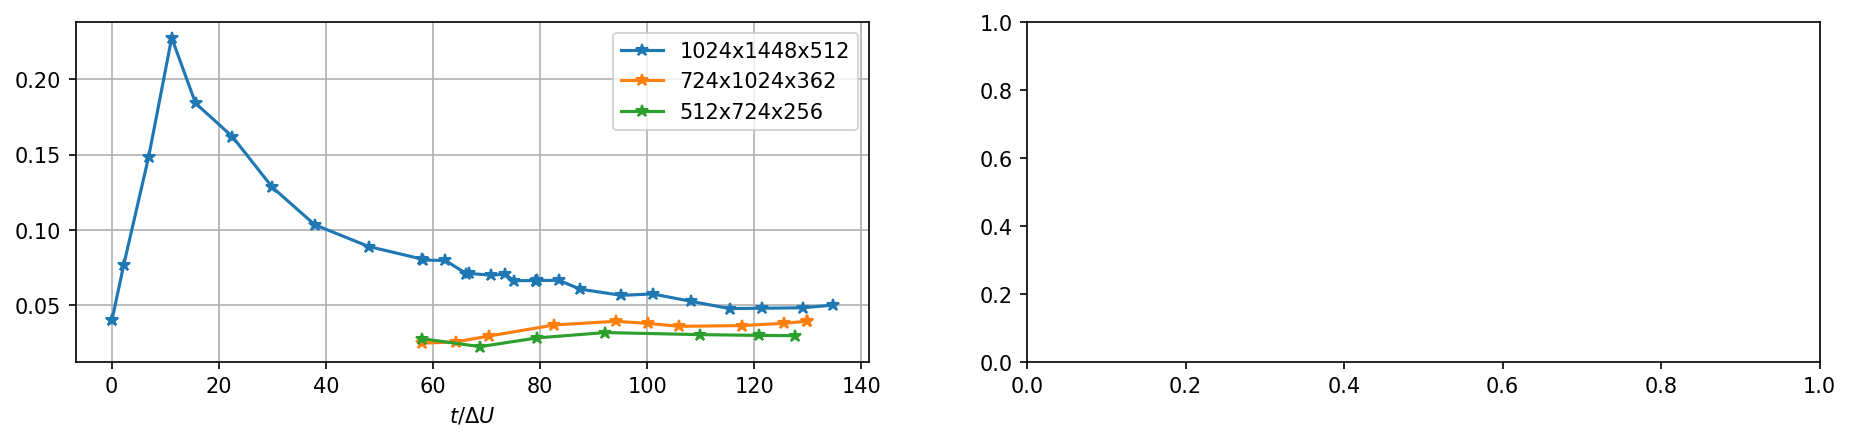

In [95]:
s = '1'
Mc = '20'
gridlist = ['1024x1448x512','724x1024x362','512x724x256']
    
fig,ax = plt.subplots(1,2,figsize=(15,3),dpi=150)

for gridres in gridlist:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/%s/'%(Mc,s,gridres)
    filename_prefix = directory + '/TKEBudget_'
    reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
    inp = nml.inputs(directory,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    steps = reader.steps
    print(directory)

    tlist,dlist,rates = growth_rates(directory+'shearlayer_')

#     matP = integrate_term(reader,steps,'production')
#     matD = integrate_term(reader,steps,'dissipation')
#     ax[0].plot(matP[:,0],matP[:,1]/matD[:,1],'-*',label='{}'.format(gridres))    
    mat = integrate_term(reader,steps,'dissipation')
    ax[0].plot(mat[:,0],mat[:,1],'-*',label='{}'.format(gridres))
    
print('Done')
print('Done')
ax[0].grid(True)
ax[0].legend()
ax[0].set_xlabel(r'$t/\Delta U$')
